In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import math
from collections import namedtuple
from tqdm.auto import tqdm as tq
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from pprint import pprint
import seaborn as sns
sns.set()

In [2]:
CLASSES = ['aquarium', 'desert', 'highway', 'kitchen', 'laundromat', 'park', 'waterfall', 'windmill']
PATHS = namedtuple('_', ('train', 'test'))('../dataset/SUN_data/train/', '../dataset/SUN_data/test/')
SIZE = (150, 150)

In [3]:
def alert(f):
    def wrapper(*args, **kwargs):
        ret = f(*args, **kwargs)
        try:
            display(Audio(audio_file, autoplay=True))
        finally:
            return ret
    from IPython.display import Audio
    audio_file = 'http://www.soundjay.com/button/beep-07.wav'
    return wrapper

def show(img, ax=None):
    if not ax:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
    else:
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        return ax

def load_test(cls, lim=None):
    path = os.path.join(PATHS.test, cls)
    imgs = os.listdir(path)
    if (lim is not None) and (len(imgs) > lim):
        imgs = imgs[:lim]
    for f in imgs:
        if f.startswith('.'):
            continue
        f_ = os.path.join(path, f)
        img = cv2.imread(f_)
        img = cv2.resize(img, SIZE, interpolation=cv2.INTER_AREA)
        yield f_, img

def load_train(cls, lim=None):
    path = os.path.join(PATHS.train, cls)
    imgs = os.listdir(path)
    if (lim is not None) and (len(imgs) > lim):
        imgs = imgs[:lim]
    for f in imgs:
        if f.startswith('.'):
            continue
        f_ = os.path.join(path, f)
        img = cv2.imread(f_)
        img = cv2.resize(img, SIZE, interpolation=cv2.INTER_AREA)
        yield f_, img
        
def load_test_all(lim=None):
    for cls in CLASSES:
        for path, img in load_test(cls, lim):
            yield cls, path, img
            
def load_train_all(lim=None):
    for cls in CLASSES:
        for path, img in load_train(cls, lim):
            yield cls, path, img

In [4]:
STEP = 5
VOCAB_SIZE = 100
SVM_LAMDA = 1
SVM_ITER = 1000

def dense_sift(img, step=STEP):
    keypoints = []
    for i in range(step//2, img.shape[0], step):
        for j in range(step//2, img.shape[1], step):
            keypoints.append(cv2.KeyPoint(j, i, step))
    
    sift = cv2.SIFT_create()
    return sift.compute(img, keypoints)

@alert
def dense_sift_batch(batch, step=STEP):
    labels = []
    paths = []
    keypoints = []
    descriptors = []
    for cls, path, img in tq(batch):
        labels.append(cls)
        paths.append(path)
        kps, desc = dense_sift(img, step)
        keypoints.append(kps)
        descriptors.append(desc)
    return labels, paths, keypoints, descriptors

def cluster(descriptors, k=VOCAB_SIZE, kmeans=None):
    descriptors_flat = np.concatenate(descriptors)
    
    if kmeans is None:
        kmeans = KMeans(n_clusters=k)
        cluster_labels = kmeans.fit_predict(descriptors_flat)
    else:
        cluster_labels = kmeans.predict(descriptors_flat)
        k = kmeans.cluster_centers_.shape[0]
    
    histograms = np.zeros((len(descriptors), k), dtype=np.float64)
    idx = 0
    for i, desc in enumerate(descriptors):
        for _ in range(desc.shape[0]):
            histograms[i, cluster_labels[idx]] += 1
            idx += 1
            
    return kmeans, histograms

class TFIDF:
    def __init__(self):
        self.log_weights = None
    def normalise(self, histograms):
        if self.log_weights is None:
            weights = np.count_nonzero(histograms, axis=0)
            self.log_weights = np.log(histograms.shape[0] / weights)
            
        return histograms * self.log_weights
    
def train_classifier(histograms, labels, num_iter=SVM_ITER, lamda=SVM_LAMDA):
    labels = np.array(labels, dtype='object')
    svm = LinearSVC(C=lamda, max_iter=num_iter, dual=(histograms.shape[0]<=histograms.shape[1])).fit(histograms, labels)
    return svm

In [5]:
tr_labels, _, _, tr_descriptors = dense_sift_batch(load_train_all())
kmeans, tr_histograms = cluster(tr_descriptors)
tfidf = TFIDF()
tr_norm_histograms = tfidf.normalise(tr_histograms)
classifier = train_classifier(tr_norm_histograms, tr_labels)

0it [00:00, ?it/s]

In [6]:
te_labels, te_paths, _, te_descriptors = dense_sift_batch(load_test_all())
_, te_histograms = cluster(te_descriptors, kmeans=kmeans)
te_norm_histograms = tfidf.normalise(te_histograms)
te_labels_pred = classifier.predict(te_norm_histograms)

0it [00:00, ?it/s]

In [7]:
def confusion(actual, predicted, classes):
    conf = np.zeros((len(classes), len(classes)), dtype=np.float64)
    
    mp = {}
    for i, cls in enumerate(classes):
        mp[cls] = i
    
    for a, p in zip(actual, predicted):
        conf[mp[a], mp[p]] += 1
    return conf / conf.sum(axis=1, keepdims=True)

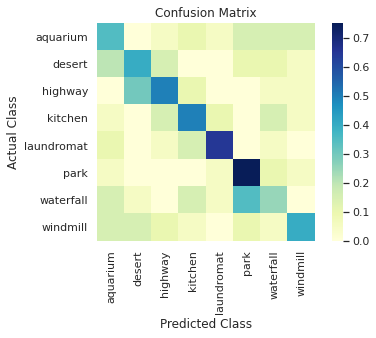

In [8]:
conf = confusion(te_labels, te_labels_pred, CLASSES)
ax = sns.heatmap(conf, cmap='YlGnBu', xticklabels=CLASSES, yticklabels=CLASSES, square=True)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
ax.set_title('Confusion Matrix')
plt.show()

In [9]:
NUM_PLOT = 10

te_labels = np.array(te_labels, dtype='object')
good_ind = np.where(np.equal(te_labels, te_labels_pred))[0]
bad_ind = np.where(np.not_equal(te_labels, te_labels_pred))[0]

acc = len(good_ind) * 100 / len(te_labels)
print(f'Accuracy: {acc}%')

good_ind = np.random.choice(good_ind, size=min(len(good_ind), NUM_PLOT), replace=False)
bad_ind = np.random.choice(bad_ind, size=min(len(bad_ind), NUM_PLOT), replace=False)

Accuracy: 47.5%


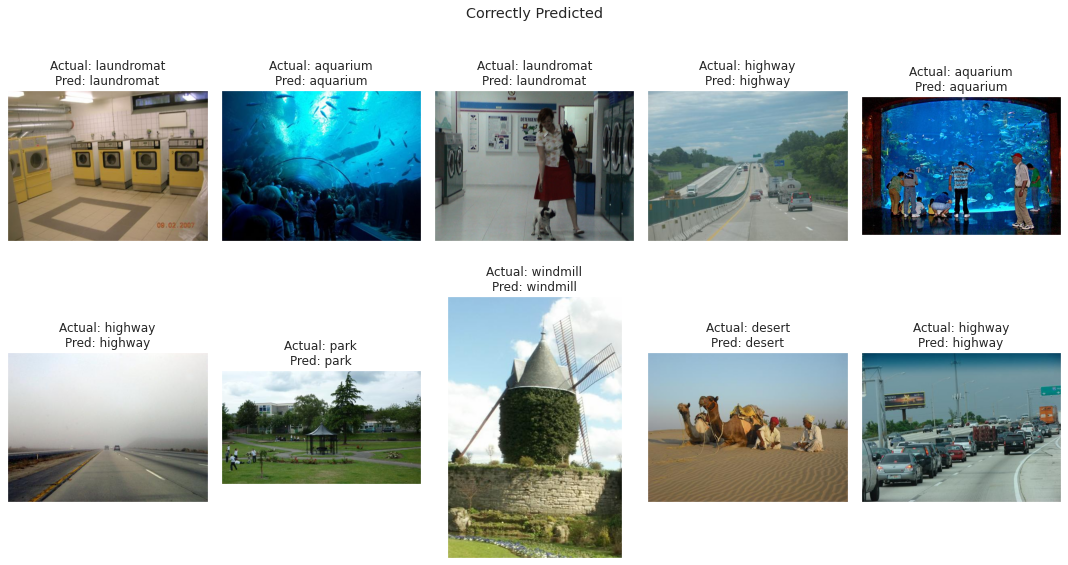

In [10]:
fig, axs = plt.subplots(2, math.ceil(len(good_ind)/2), figsize=(15, 8))

for i, ax in enumerate(axs.flat):
    if i >= len(good_ind):
        ax.imshow(np.ones((75, 75, 3)))
        ax.axis('off')
        continue
    
    idx = good_ind[i]
    img = cv2.imread(te_paths[idx])
    ax = show(img, ax)
    ax.set_title(f'Actual: {te_labels[idx]}\nPred: {te_labels_pred[idx]}')
    ax.set_xticks([], minor=[])
    ax.set_yticks([], minor=[])

fig.suptitle('Correctly Predicted')
fig.tight_layout()
plt.show()

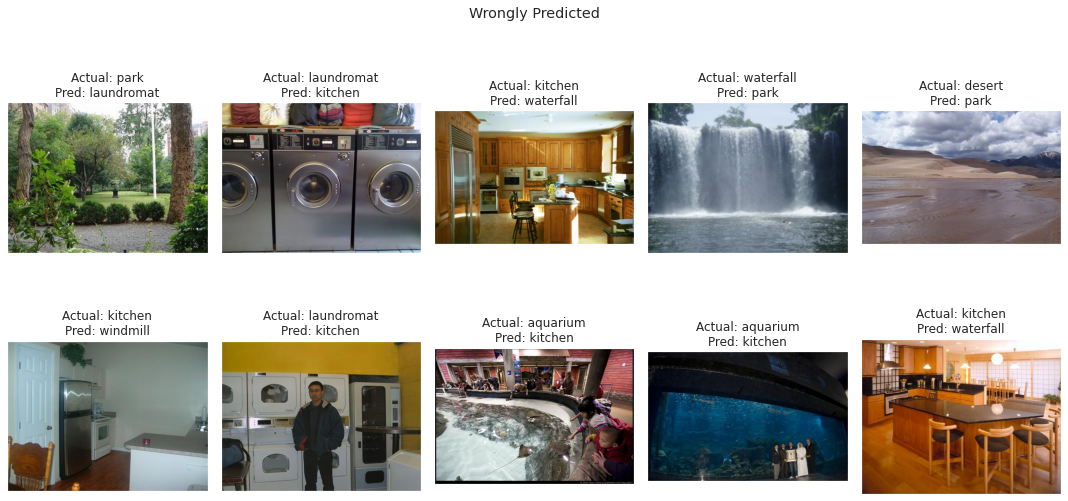

In [11]:
fig, axs = plt.subplots(2, math.ceil(len(bad_ind)/2), figsize=(15, 8))

for i, ax in enumerate(axs.flat):
    if i >= len(bad_ind):
        ax.imshow(np.ones((75, 75, 3)))
        ax.axis('off')
        continue
    
    idx = bad_ind[i]
    img = cv2.imread(te_paths[idx])
    ax = show(img, ax)
    ax.set_title(f'Actual: {te_labels[idx]}\nPred: {te_labels_pred[idx]}')
    ax.set_xticks([], minor=[])
    ax.set_yticks([], minor=[])

fig.suptitle('Wrongly Predicted')
fig.tight_layout()
plt.show()